In [1]:
import matplotlib.pyplot as plt

import  seaborn as sns
sns.set_style("darkgrid")

from Utils import *
from ExperientalTools import *

import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
%reload_ext autoreload
%autoreload 2

## get the dataset

In [2]:
(tr_x,tr_y) = prepare_dataset(train_path="datasets/ML-CUP21-TR.csv",unique=True)
results = {}

## Constants

In [3]:
SIZE_RESERVOIR = 200
LAMBDA_REG = 0.01
MAX_ITER = 8000
PRECISION = 1e-2
LR = 0 # 1/(L+tau) will be chosen if LR=0

## fix the resevoir

In [4]:
resevoir = np.random.uniform(-1, 1, (SIZE_RESERVOIR, 10))

In [5]:
H = sigmoid(resevoir@tr_x)

In [6]:
condition_number = np.linalg.cond(H)
print(f"Condition number of H: {condition_number}")

Condition number of H: 2856.234602273473


# OPTIMAL SOLUTION

In [7]:
%%time
w_star,_,_,_ = np.linalg.lstsq(H.T, tr_y.T,rcond=-1)

CPU times: total: 125 ms
Wall time: 10 ms


In [8]:
optimal_mse, optimal_rel_gap_pred = mse(w_star.T@H, tr_y), get_rel_gap_pred(tr_y, y_pred=w_star.T@H)
results["optimal"] = (optimal_mse, optimal_rel_gap_pred)

In [9]:
print("Mean square error: ", optimal_mse)
print("Relative Gap Pred: ", optimal_rel_gap_pred)

Mean square error:  1.341361267457342
Relative Gap Pred:  0.07541525319157028


## Cholesky solution

In [10]:
%%time
model = fit_cholesky(tr_x,tr_y, lambda_=LAMBDA_REG, activation="sig", resevoir=resevoir)

CPU times: total: 1.25 s
Wall time: 152 ms


In [11]:
mse_cholesky, cholesky_rel_gap_pred = get_results(model, tr_x, tr_y)
results["cholesky"] = (mse_cholesky, cholesky_rel_gap_pred)
cholesky_rel_gap_sol = np.linalg.norm(model.w2 - w_star.T)/np.linalg.norm(w_star)

In [12]:
print("Mean square error: ", mse_cholesky)
print("Relative Gap Pred: ", cholesky_rel_gap_pred)
print("Relative Gap Sol: ", cholesky_rel_gap_sol)

Mean square error:  1.3478975127755939
Relative Gap Pred:  0.07559877331032995
Relative Gap Sol:  0.28994597799966815


## Iterative methods

In [13]:
%%time
classical_sgd = fit_sgd(x_train=tr_x, y_train=tr_y, lambda_=LAMBDA_REG, activation="sig", max_inters=MAX_ITER,
                        eps=PRECISION, lr=LR, beta=0, resevoir=resevoir, minimum=optimal_mse, w_star=w_star.T)

SGD max iterations reached
CPU times: total: 1min 13s
Wall time: 9.83 s


In [14]:
mse_classical_sgd, sgd_rel_gap_pred = get_results(classical_sgd[0], tr_x, tr_y)
results["classical-SGD"] = (mse_classical_sgd, sgd_rel_gap_pred)

In [15]:
print("Mean square error: ", mse_classical_sgd)
print("Relative Gap Pred: ", sgd_rel_gap_pred)
print("Relative Gap Sol: ", classical_sgd[1]["Rel_Gap_Sol"].tail(1).values[0])

Mean square error:  1.9260353462178392
Relative Gap Pred:  0.09036878412575165
Relative Gap Sol:  0.9816226526543052


In [16]:
# %%time
# momentum_sgd = fit_sgd(x_train=tr_x, y_train=tr_y, lambda_=LAMBDA_REG, activation="sig", max_inters=MAX_ITER,
#                        eps=PRECISION, lr=0, beta=0.99, resevoir=resevoir, minimum=optimal_mse, w_star=w_star.T)

In [17]:
# mse_momentum_sgd, residual_momentum_sgd = get_results(momentum_sgd[0],tr_x,tr_y)
# results["momentum-SGD"] = (mse_momentum_sgd, residual_momentum_sgd)

In [18]:
%%time
fista = fit_fista(x_train=tr_x, y_train=tr_y, lambda_=LAMBDA_REG, activation="sig", max_inters=MAX_ITER,
                  eps=PRECISION, resevoir=resevoir, minimum=optimal_mse, w_star=w_star.T)

FISTA max iterations reached
CPU times: total: 1min 14s
Wall time: 10.1 s


In [19]:
mse_fista, fista_rel_gap_pred = get_results(fista[0], tr_x, tr_y)
results["fista"] = (mse_fista, fista_rel_gap_pred)

In [20]:
print("Mean square error: ", mse_fista)
print("Relative Gap Pred: ", fista_rel_gap_pred)
print("Relative Gap Sol: ", fista[1]["Rel_Gap_Sol"].tail(1).values[0])

Mean square error:  1.3424682325972184
Relative Gap Pred:  0.07544636518277252
Relative Gap Sol:  0.128125983738751


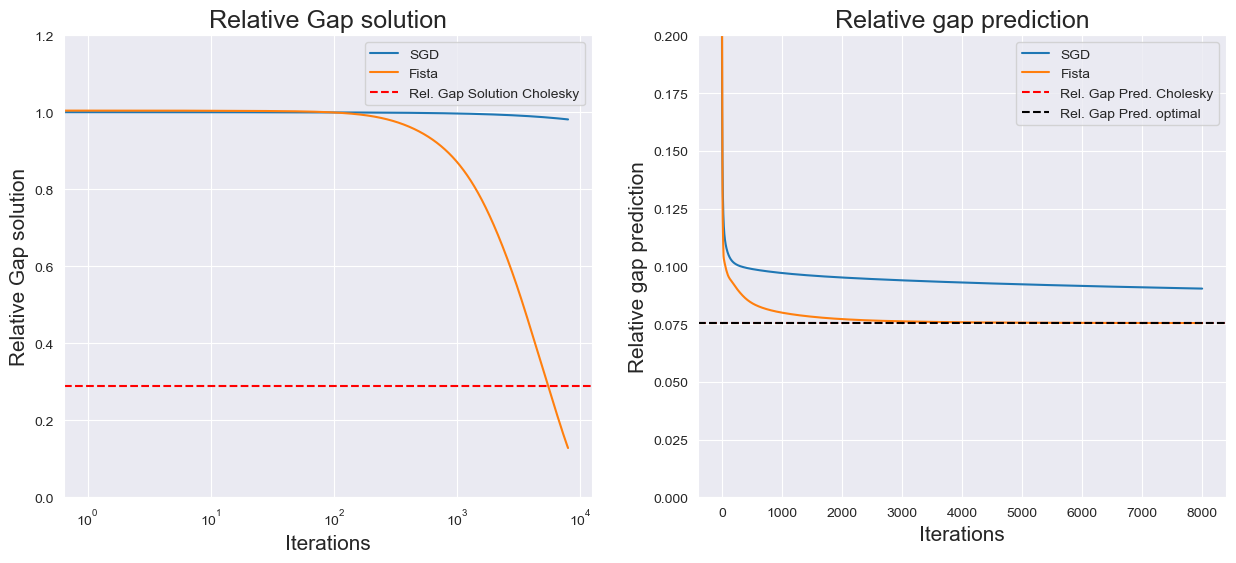

In [21]:
_, axs = plt.subplots(ncols=2,figsize=(15,6))

sns.lineplot(data=classical_sgd[1], x=classical_sgd[1].index, y="Rel_Gap_Sol", ax=axs[0], label="SGD")
sns.lineplot(data=fista[1], x=fista[1].index, y="Rel_Gap_Sol", ax=axs[0], label="Fista")
axs[0].axhline(y=cholesky_rel_gap_sol, label="Rel. Gap Solution Cholesky", color="red", linestyle="--")
axs[0].set_title("Relative Gap solution",fontsize=18)
axs[0].set_ylabel("Relative Gap solution",fontsize=15)
axs[0].set_xlabel("Iterations",fontsize=15)
axs[0].set_ylim([0.00,1.2])
# sns.lineplot(data=momentum_sgd[1], x=momentum_sgd[1].index, y="Rel_Gap_Sol", ax=axs[0], label="SGD-M")
axs[0].set_xscale("log")
axs[0].legend()

sns.lineplot(data=classical_sgd[1], x=classical_sgd[1].index, y="Rel_Gap_pred", ax=axs[1], label="SGD")
sns.lineplot(data=fista[1], x=fista[1].index, y="Rel_Gap_pred", ax=axs[1], label="Fista")
axs[1].axhline(y=cholesky_rel_gap_pred, label="Rel. Gap Pred. Cholesky", color="red", linestyle="--")
axs[1].axhline(y=optimal_rel_gap_pred, label="Rel. Gap Pred. optimal", color="black", linestyle="--")
axs[1].set_title("Relative gap prediction",fontsize=18)
axs[1].set_ylabel("Relative gap prediction",fontsize=15)
axs[1].set_xlabel("Iterations",fontsize=15)
axs[1].set_ylim([0,0.2])
axs[1].legend()
# sns.lineplot(data=momentum_sgd[1], x=momentum_sgd[1].index, y="Rel_Gap_pred", ax=axs[1], label="SGD-M")
plt.show()


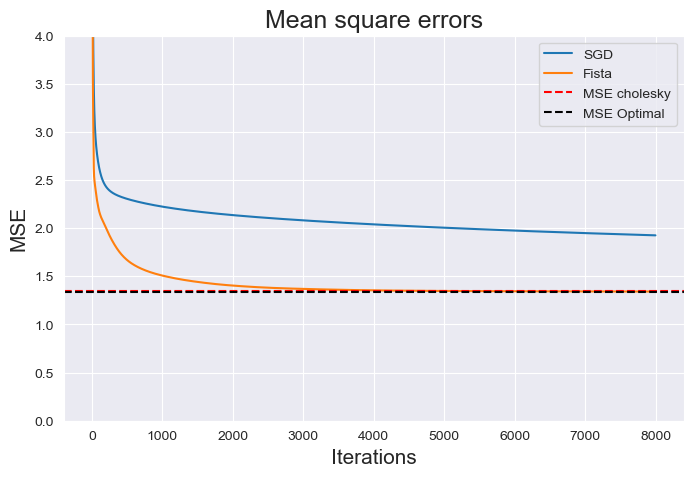

In [22]:
_, axs = plt.subplots(figsize=(8,5))

sns.lineplot(data=classical_sgd[1], x=classical_sgd[1].index, y="MSE", ax=axs, label="SGD")
sns.lineplot(data=fista[1], x=fista[1].index, y="MSE", ax=axs, label="Fista")
axs.axhline(y=mse_cholesky, label="MSE cholesky", color="red", linestyle="--")
axs.axhline(y=optimal_mse, label="MSE Optimal", color="black", linestyle="--")
axs.set_title("Mean square errors",fontsize=18)
axs.set_ylabel("MSE",fontsize=15)
axs.set_xlabel("Iterations",fontsize=15)
axs.set_ylim([0,4])
axs.legend()
# sns.lineplot(data=momentum_sgd[1], x=momentum_sgd[1].index, y="MSE", ax=axs, label="SGD-M")
plt.show()


In [23]:
# print(f"{'Method' : ^20}{'MSE' : ^12}{'Rel. gap pred' : ^12}")
# 
# for k,v in results.items():
#     print(f"{k : ^20}{round(v[0],4):^12}{round(v[1],5) : ^12}")